#***Email Spam Detection***

> 'Email, instant messaging, and cell phones give us fabulous communication ability, but because we live and work in our own little worlds, that communication is totally disorganized' - Marilyn vos Savant" ~ George Veditz

In [ ]:
# Libraries
import numpy as np
import pandas as pd
import nltk
import string
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

## **Email Spam Dataset:**

  ***Dataset Contains:***

        1. Category
        
        2. Message

  ***Message Type:***

        1. Ham (Not Spam)

        2. Spam

In [ ]:
# Dataset
file_link = 'https://drive.google.com/file/d/1Q46Q2x_pjDnr-WjTarHQ_SYdGjRTznPg/view?usp=sharing'
id = file_link.split("/")[-2]

# Creating a new link using the id so that we can easily read the csv file in pandas
new_link = f'https://drive.google.com/uc?id={id}'
dataset = pd.read_csv(new_link)

dataset.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [ ]:
print('Dataset Matrix:', dataset.shape)

Dataset Matrix: (5572, 2)


#Data Pre-Processing

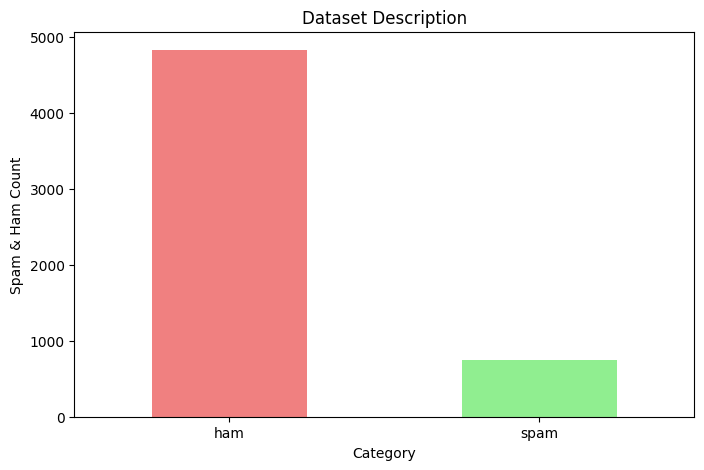

In [ ]:
# Visualization of Dataset
plt.figure(figsize=(8, 5))
dataset['Category'].value_counts().plot(kind='bar', color=['lightcoral', 'lightgreen'])
plt.title('Dataset Description')
plt.xlabel('Category')
plt.ylabel('Spam & Ham Count')
plt.xticks(rotation = 0)
plt.show()

In [ ]:
dataset.isnull().sum() # Checking if there is any null values in the dataset.

Category    0
Message     0
dtype: int64

In [ ]:
dataset.loc[dataset['Category'] == 'spam', 'Category',] = 0 # If 0, it is a Spam.
dataset.loc[dataset['Category'] == 'ham', 'Category',] = 1 # If 1, it is a Ham (Not a Spam).

In [ ]:
dataset['Num_Characters'] = dataset['Message'].apply(len) # To Count Length.
dataset['Num_Words'] = dataset['Message'].apply(lambda x:len(nltk.word_tokenize(x))) # To Count Words.
dataset['Num_Sentences'] = dataset['Message'].apply(lambda x:len(nltk.sent_tokenize(x))) # To Count Sentences.
dataset.head()

,Category,Message,Num_Characters,Num_Words,Num_Sentences
0,1,"Go until jurong point, crazy.. Available only ...",111,24,2
1,1,Ok lar... Joking wif u oni...,29,8,2
2,0,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2
3,1,U dun say so early hor... U c already then say...,49,13,1
4,1,"Nah I don't think he goes to usf, he lives aro...",61,15,1


In [ ]:
# Make The Sentence -> Lowercase, Tokenization, Removing SpecialChar, Removing Stop Words & Punchuation, Stemming

def transform_text(text):
  text = text.lower()
  text = nltk.word_tokenize(text) #Tokenization
  y = []

  for i in text:
    if i.isalnum():
      y.append(i) # Not Taking Any Special Characters

  text = y
  y = []

  for i in text:
    if i not in stopwords.words('english') and i not in string.punctuation:
      y.append(i)

  text = y
  y = []

  for i in text:
    y.append(PorterStemmer().stem(i)) # For Example: It will make Dancing to Dance, Going to Go, etc. (Stemming)

  return ' '.join(y)

dataset['Transformed_Messages'] = dataset['Message'].apply(transform_text)

dataset.head()

,Category,Message,Num_Characters,Num_Words,Num_Sentences,Transformed_Messages
0,1,"Go until jurong point, crazy.. Available only ...",111,24,2,go jurong point crazi avail bugi n great world...
1,1,Ok lar... Joking wif u oni...,29,8,2,ok lar joke wif u oni
2,0,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2,free entri 2 wkli comp win fa cup final tkt 21...
3,1,U dun say so early hor... U c already then say...,49,13,1,u dun say earli hor u c alreadi say
4,1,"Nah I don't think he goes to usf, he lives aro...",61,15,1,nah think goe usf live around though


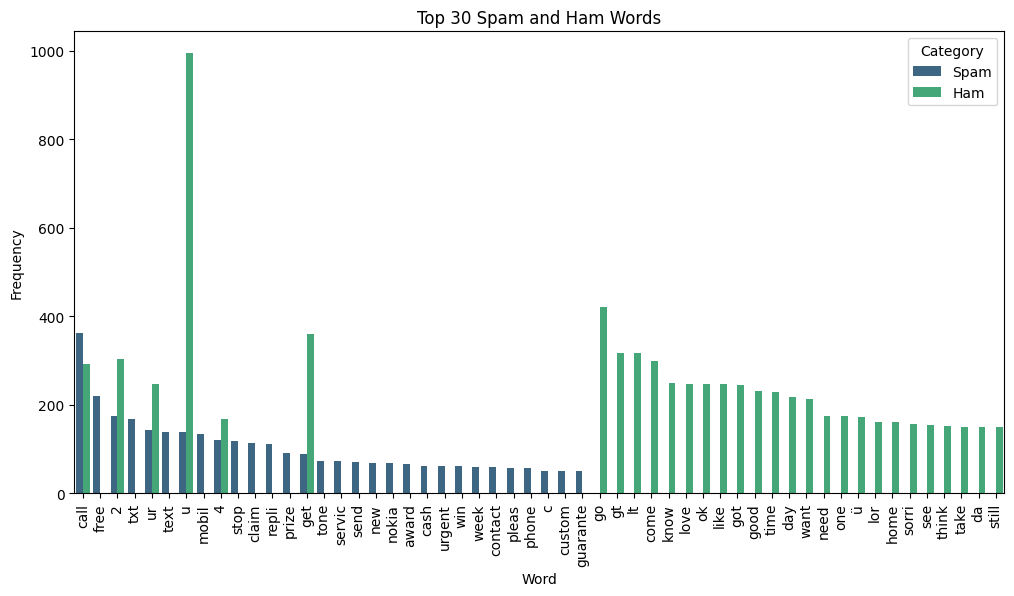

In [ ]:
# Visualize Most Occured Spam & Ham Words

def plot_word_occurrence(data, title):
    plt.figure(figsize=(12, 6))
    sns.barplot(x='Word', y='Frequency', data=data, hue='Category', palette='viridis')
    plt.title(title)
    plt.xlabel('Word')
    plt.ylabel('Frequency')
    plt.xticks(rotation=90)
    plt.legend(title='Category')
    plt.show()

# Top 30 Spam Words
spams = []
for sentences in dataset[dataset['Category'] == 0]['Transformed_Messages'].tolist():
    for word in sentences.split():
        spams.append(word)

spams_df = pd.DataFrame(Counter(spams).most_common(30), columns=['Word', 'Frequency'])
spams_df['Category'] = 'Spam'

# Top 30 Ham Words
hams = []
for sentences in dataset[dataset['Category'] == 1]['Transformed_Messages'].tolist():
    for word in sentences.split():
        hams.append(word)

hams_df = pd.DataFrame(Counter(hams).most_common(30), columns=['Word', 'Frequency'])
hams_df['Category'] = 'Ham'

combined_df = pd.concat([spams_df, hams_df])
plot_word_occurrence(combined_df, 'Top 30 Spam and Ham Words')

#Preparing Training Dataset

> 'It is a capital mistake to theorize before one has data' - Arthur Conan Doyle

In [ ]:
#Text Vectorization (Convert Textual Data to Number)
cv = CountVectorizer()
messages = cv.fit_transform(dataset['Transformed_Messages']).toarray()

label_encoder = LabelEncoder()
categories = label_encoder.fit_transform(dataset['Category'].values)


In [ ]:
# Split Train Test Data
x_train, x_test, y_train, y_test = train_test_split(messages, categories, test_size=0.3, random_state=101)

#Gausian Naive Bayes Model

In [ ]:
# Gaissian Naive Bayes
gnb = GaussianNB()
gnb.fit(x_train, y_train)
prediction_gnb = gnb.predict(x_test)
accuracy_gnb = accuracy_score(y_test, prediction_gnb)
print('Accuracy Score:', accuracy_gnb)
precision_gnb = precision_score(y_test, prediction_gnb)
print('Precision Score:', precision_gnb)

Accuracy Score: 0.8636363636363636
Precision Score: 0.9829589465530596


#Multinomial Naive Bayes Model

In [ ]:
mnb = MultinomialNB()
mnb.fit(x_train, y_train)
prediction_mnb = mnb.predict(x_test)
accuracy_mnb = accuracy_score(y_test, prediction_mnb)
print('Accuracy Score:', accuracy_mnb)
precision_mnb = precision_score(y_test, prediction_mnb)
print('Precision Score:', precision_mnb)

Accuracy Score: 0.9742822966507177
Precision Score: 0.9890710382513661


#Logistic Regression Model

In [ ]:
lr = LogisticRegression()
lr.fit(x_train, y_train)
prediction_lr = lr.predict(x_test)
accuracy_lr = accuracy_score(y_test, prediction_lr)
print('Accuracy Score:', accuracy_lr)
precision_lr = precision_score(y_test, prediction_lr)
print('Precision Score:', precision_lr)

Accuracy Score: 0.9766746411483254
Precision Score: 0.9761273209549072


#Comparison Between:

    1.   Gausian Naive Bayes Model
    2.   Multinomial Naive Bayes Model
    3.   Logistic Regression Model



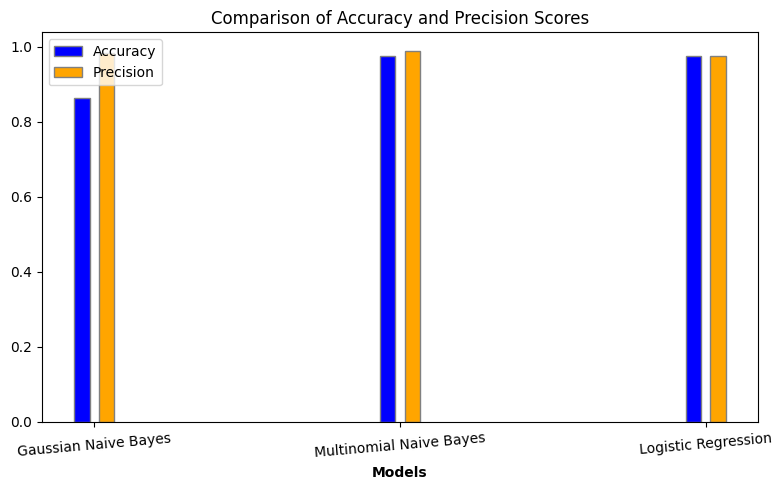

In [ ]:
#Visualization of Models' Scores

models = ['Gaussian Naive Bayes', 'Multinomial Naive Bayes', 'Logistic Regression']

# Accuracy scores
accuracy_scores = [accuracy_gnb, accuracy_mnb, accuracy_lr]

# Precision scores
precision_scores = [precision_gnb, precision_mnb, precision_lr]


# Set the positions of the bars on the x-axis
r1 = []
for i in range(len(models)):
  r1.append(i)

r2 = []
for i in range(len(models)):
  r2.append(0.08+r1[i])

# Plotting
plt.figure(figsize=(8, 5))

plt.bar(r1, accuracy_scores, color='blue', width=0.05, edgecolor='grey', label='Accuracy')
plt.bar(r2, precision_scores, color='orange', width=0.05, edgecolor='grey', label='Precision')

plt.xlabel('Models', fontweight='bold')
plt.xticks([r + 0.04 for r in range(len(models))], models)
plt.xticks(rotation=5)
plt.title('Comparison of Accuracy and Precision Scores')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
#Comparing Score between Models

def balance_score(accuracy, precision):
    return ( ( 0.5 * accuracy ) + ( 0.5 * precision ) )

balance_score_gnb = balance_score(accuracy_gnb, precision_gnb)
balance_score_mnb = balance_score(accuracy_mnb, precision_mnb)
balance_score_lr = balance_score(accuracy_lr, precision_lr)

if balance_score_gnb > balance_score_mnb and balance_score_gnb > balance_score_lr:
  print('Gaussian Naive Bayes is giving more precise predictions.')
elif balance_score_mnb > balance_score_gnb and balance_score_mnb > balance_score_lr:
  print('Multinomial Naive Bayes is giving more precise predictions.')
elif balance_score_lr > balance_score_gnb and balance_score_lr > balance_score_lr:
  print('Multinomial Naive Bayes is giving more precise predictions.')
else:
  print('This Else block is useless! In no condition, we will ever reach this block :v ')

Multinomial Naive Bayes is giving more precise predictions.
